In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
people = ["sender", "recipient"]
levels = ["email", "sentence", "word"]
data_sets = ["test", "fairframe"]
results = {person: 
           {level:
            {data_set:
             pd.read_csv("results/%s/%s/%s.csv"%(person,level,data_set))
             for data_set in data_sets}
            for level in levels}
           for person in people}

In [3]:
len(results["sender"]["email"]["test"])

3097

In [4]:
len(results["recipient"]["email"]["test"])

3441

# ROC Plots

In [19]:
def rocplot(truth, pred, name, c):
    
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = metrics.roc_curve(truth, -1 * pred)
        roc_auc = metrics.auc(fpr, tpr)
        
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")

In [20]:
def roc_level_plot(df_dict, level, filename=None):
    sender_test = df_dict["sender"][level]["test"]
    recipient_test = df_dict["recipient"][level]["test"]
    sender_fair = df_dict["sender"][level]["fairframe"]
    recipient_fair = df_dict["recipient"][level]["fairframe"]
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(111)
    plt.title("Fasttext ROC on the %s level" %(level))
    rocplot(sender_test.true_label =="F", sender_test["prob of F"],
            "Enron Sender Gender on %s level" % (level), "r")
    rocplot(recipient_test.true_label =="F", recipient_test["prob of F"],
            "Enron Recipient Gender on %s level" % (level), "b")
    rocplot(sender_fair.true_label =="F", sender_fair["prob of F"],
            "FairFrame Author Gender on %s level" % (level), "g")
    rocplot(recipient_fair.true_label =="F", recipient_fair["prob of F"],
            "FairFrame Recipient Gender on %s level" % (level), "c")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
    lgd = ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True,
                    shadow = True, ncol = 2, prop = {'size':10})
    if filename:
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')

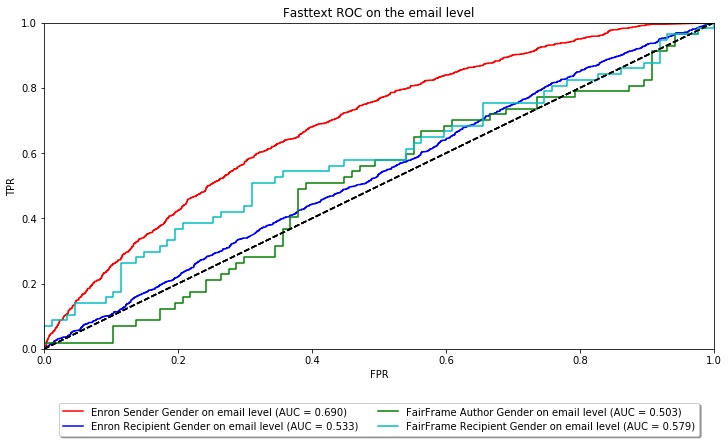

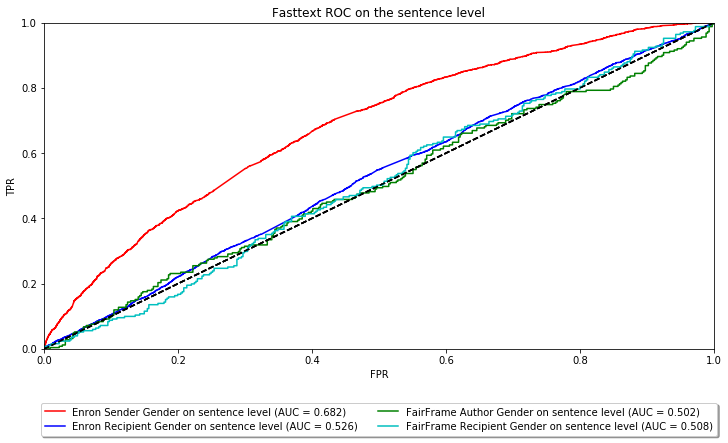

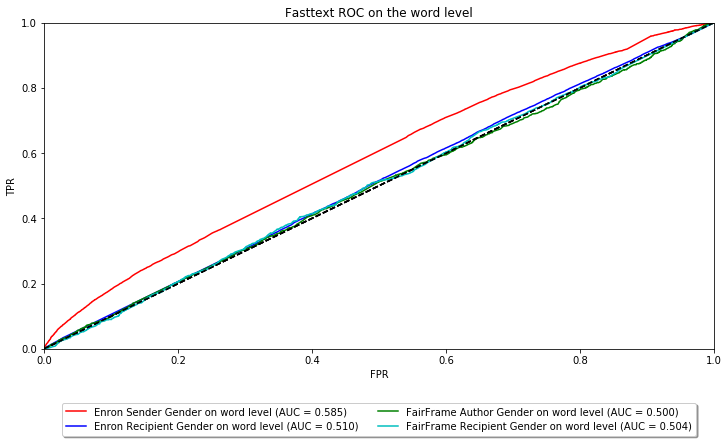

In [21]:
roc_level_plot(results, "email", "email_roc.png")
roc_level_plot(results, "sentence", "sentence_roc.png")
roc_level_plot(results, "word", "word_roc.png")

# Metrics

In [65]:
def get_metric_df(df_dict):
    set_dict = {"fairframe":"FairFrame test set",
                "test": "Enron test set"}
    data = []
    index = []
    columns = ["accuracy",
               "precision_F",
               "recall_F",
               "F1_score_F",
               "precision_M",
               "recall_M",
               "F1_score_M",
               "AUC"]
    for person, levels in df_dict.items():
        for level, dfs in levels.items():
            for data_set, df in dfs.items():
                truth, pred = df.true_label == "F", df["prob of F"]
                current_data = []
                current_data.append(metrics.accuracy_score(df.true_label == "F", df.predicted_label == "F"))
                current_data.extend((
                    np.array(metrics.precision_recall_fscore_support
                             (df.true_label == "F", df.predicted_label == "F"))[:-1,1].tolist()
                ))
                current_data.extend((
                    np.array(metrics.precision_recall_fscore_support
                             (df.true_label == "M", df.predicted_label == "M"))[:-1,1].tolist()
                ))
                current_data.append(metrics.roc_auc_score(truth, pred))
                data.append(current_data)
                index.append("Gender of %s at %s level on %s" %(person, level, set_dict[data_set]))
    else:
        data = pd.DataFrame(data, index, columns)
    return data

In [66]:
get_metric_df(results)

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy,precision_F,recall_F,F1_score_F,precision_M,recall_M,F1_score_M,AUC
Gender of sender at email level on Enron test set,0.665806,0.515238,0.507029,0.511101,0.743039,0.749261,0.746137,0.690395
Gender of sender at email level on FairFrame test set,0.583333,0.444444,0.210526,0.285714,0.615385,0.827586,0.705882,0.497479
Gender of sender at sentence level on Enron test set,0.683451,0.538644,0.333088,0.411631,0.720923,0.857927,0.783481,0.682026
Gender of sender at sentence level on FairFrame test set,0.624277,0.448276,0.155378,0.230769,0.649587,0.891156,0.751434,0.497796
Gender of sender at word level on Enron test set,0.672898,0.505384,0.122936,0.197765,0.687420,0.941284,0.794567,0.584938
Gender of sender at word level on FairFrame test set,0.608535,0.395833,0.094106,0.152061,0.629232,0.914555,0.745527,0.499737
Gender of recipient at email level on Enron test set,0.522232,0.505442,0.447590,0.474760,0.534754,0.591802,0.561834,0.533450
Gender of recipient at email level on FairFrame test set,0.493056,0.318182,0.245614,0.277228,0.570000,0.655172,0.609626,0.421254
Gender of recipient at sentence level on Enron test set,0.523247,0.491632,0.442041,0.465519,0.546358,0.595169,0.569720,0.525570
Gender of recipient at sentence level on FairFrame test set,0.498555,0.335616,0.390438,0.360958,0.617500,0.560091,0.587396,0.491946


# Example of instances and their Probabilities

In [144]:
n = 3
set_dict = {"fairframe":"FairFrame test set",
            "test": "Enron test set"}
for person, levels in results.items():
    for level, dfs in levels.items():
        for data_set, df in dfs.items():
            print("Top %s examples of %ss from predicting %s gender on the %s \n" % 
                  (n, level, person, set_dict[data_set]))
            current_df = df.sort_values("prob_of_predicted_label", 0, False)\
                         .head(n)[["content", "prob_of_predicted_label", 'predicted_label', "true_label"]]
            for i in range(n):
                print("%s \n (%s with probability %s while actually %s) \n"%
                      (current_df.content.iloc[i],
                       current_df['predicted_label'].iloc[i],
                       current_df["prob_of_predicted_label"].iloc[i],
                       current_df["true_label"].iloc[i]))

Top 3 examples of emails from predicting sender gender on the Enron test set 

Lets dummyname it up!   -----Original Appointment----- 
 (M with probability 1.0 while actually F) 

lets talk re: this.  I'm troubled.  df 
 (M with probability 1.0 while actually M) 

No I'm dummyname in bed.  Please print--I'll dummyname in in an hour dummyname so.  Thnaks.DF 
 (M with probability 1.0 while actually M) 

Top 3 examples of emails from predicting sender gender on the FairFrame test set 

ExceptionalMostly good but often focused on the selfCould improve relationships with others . 
 (M with probability 0.9999940395355223 while actually F) 

You have demonstrated not only exceptional knowledge and expertise in the space but also leadership and client engagement skills . The client meetings we had in the US were a great example to your business skills and talentI have enjoyed working with you .Keep up the good work . 
 (M with probability 0.9999819993972778 while actually M) 

Thought you were

In [120]:
results["sender"]["email"]["test"].sort_values("prob_of_predicted_label", 0, False).head(10)

,Unnamed: 0,true_label,predicted_label,prob_of_predicted_label,prob of F,prob of M,content,text
2448,42420,F,M,1.0,0.0,1.0,Lets dummyname it up! -----Original Appointm...,lets dummyname -----original appointment-----
439,27820,M,M,1.0,0.0,1.0,lets talk re: this. I'm troubled. df,lets talk i'm troubled df
983,28195,M,M,1.0,0.0,1.0,No I'm dummyname in bed. Please print--I'll d...,i'm dummyname bed please print--i'll dummyname...
450,27674,M,M,1.0,0.0,1.0,pls print for me. thanks df =20,pls print thanks df =20
2238,28518,M,M,1.0,0.0,1.0,pls print. thanks. df,pls print thanks df
814,21675,M,M,1.0,0.0,1.0,that is correct thxs dummyname,correct thxs dummyname
120,8311,M,M,1.0,0.0,1.0,"Good response, Bob. Thanks for leading dummyn...",good response bob thanks leading dummyname dum...
2242,28183,M,M,1.0,0.0,1.0,pls print. thanks. DF,pls print thanks df
440,11823,M,M,1.0,0.0,1.0,Pam- Please send this to RAC worldwide. Tx dum...,pam- please send rac worldwide tx dummyname
123,27786,M,M,1.0,0.0,1.0,pls print. thanks df,pls print thanks df


In [127]:
import random
def worst_example_finder(pred_df, num_examples = 10, p =0.7):
    choose_from = pred_df[:][pred_df.true_label != pred_df.predicted_label]
    chosen = choose_from[:][choose_from["prob_of_predicted_label"] >= p]
    probs = chosen["prob_of_predicted_label"]
    labels = chosen["predicted_label"]
    num_examples = min([num_examples, len(chosen)])
    for i in range(num_examples):
        rando = int(random.random()*len(chosen))
        print(chosen.content.iloc[rando]+" \n (With probability %s as %s) \n"
              %(probs.iloc[rando], labels.iloc[rando]) )

In [128]:
def best_example_finder(pred_df, num_examples = 10, p = 0.7):
    choose_from = pred_df[:][pred_df.true_label == pred_df.predicted_label]
    chosen = choose_from[:][choose_from["prob_of_predicted_label"] >= p]
    probs = chosen["prob_of_predicted_label"]
    labels = chosen["predicted_label"]
    num_examples = min([num_examples, len(chosen)])
    for i in range(num_examples):
        rando = int(random.random()*len(chosen))
        print(chosen.content.iloc[rando]+" \n (With probability %s as %s) \n"
              %(probs.iloc[rando], labels.iloc[rando]) )

In [132]:
#note that the words tend to have very even probability of being either gender
set_dict = {"fairframe":"FairFrame test set",
            "test": "Enron test set"}
p_w = 0.5
p_r = 0.5
for person, levels in results.items():
    for level, dfs in levels.items():
        for data_set, df in dfs.items():
            print("Random incorrectly labelled %ss from predicting %s gender on the %s \n with probability at least %s \n" % 
                  (level, person, set_dict[data_set], p_w))
            worst_example_finder(df, 2, p_w)
            print(" \n")
            print("Random correctly labelled %ss from predicting %s gender on the %s \n with probability at least %s \n" % 
                  (level, person, set_dict[data_set], p_r))
            best_example_finder(df, 2, p_r)
            print(" \n")
            

Random incorrectly labelled emails from predicting sender gender on the Enron test set 
 with probability at least 0.5 

Have dummyname dummyname of dummyname Mary? 
 (With probability 0.999923825263977 as M) 

--------- Inline attachment follows --------- 
 (With probability 1.0 as M) 

 

Random correctly labelled emails from predicting sender gender on the Enron test set 
 with probability at least 0.5 

dummyname dummyname upgrade dummyname to first class? 
 (With probability 0.9472268223762512 as M) 

Due to VAR reasons, dummyname and I  both need to sell today.  dummyname and dummyname are  going up, implying Enron dummyname carry fewer contracts today dummyname dummydate  Have  your desk net sell dummynumber today. dummyname 
 (With probability 0.9993543028831482 as M) 

 

Random incorrectly labelled emails from predicting sender gender on the FairFrame test set 
 with probability at least 0.5 

GreatWorked well , great communication skillsCould be a better mentor to new employ

In [125]:
"%ss" %("dog")

'dogs'